## Advanced Lane Finding


Vivek´s cookbook for this project:
(https://medium.com/@vivek.yadav/robust-lane-finding-using-advanced-computer-vision-techniques-mid-project-update-540387e95ed3#.dr4q5d4xr)
    

1) Undistort camera image and apply perspective transform to get a bird-eye view of the street.

2) Convert to HSV colorspace and apply color mask to identify yellow lines

3) Apply Sobel filters to get image with potential line/edges

4) Combine binary masks from Sobel filters and HSV color masks

5) Apply moving average filter to remove any markings or features that could be due to other artifacts in the image.

6) Apply polynomial regression to compute the left and right lanes

7) Apply frame to frame smoothing to discard noise between images, and draw lines back on the image.

8) Compute curvature and lane deviation and write them on the image.

In [195]:
#Loading Dependencies
import numpy as np
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
#%matplotlib qt 
%matplotlib inline

print("Dependencies Loaded Sucessfully !")

Dependencies Loaded Sucessfully !


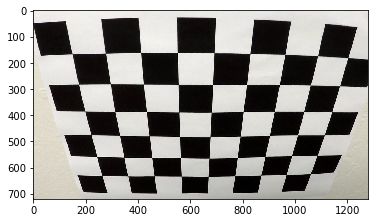

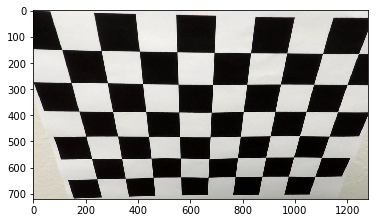

In [196]:
# 1 - Work on Camera Distortion Matrix with multiple given calibration pictures
# Camera Distortion and Undistortion codes are the same explained in the class
# Code from Udacity CARND Term 1

#loading all calibration images using glob
images = glob.glob('camera_cal/calibration*.jpg')

#Here some calibration parameters, like size of the calibration pictures and number of edges. These are set manually.
calib_x = 720
calib_y = 1280
calib_num = 20
edge_x = 9
edge_y = 6


#Define arrays to store objects and image points from all images
objpoints = [] # 3D points in real world images
imgpoints = [] # 2D points in image plane

objp = np.zeros((edge_y*edge_x,3),np.float32)
objp[:,:2] = np.mgrid[0:edge_x,0:edge_y].T.reshape(-1,2) #x,y coordinates


for fname in images:
    #read in each images
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (edge_x,edge_y),None)
    
    if ret == True:
        #if corners are found, register them
        imgpoints.append(corners)
        objpoints.append(objp)


#Calculate the calibration parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
#Only mtx and dist are relevant in this project




#Testing the results
file_name = "camera_cal/calibration2.jpg"
img = mpimg.imread(file_name)

plt.imshow(img)
plt.show()

dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)
plt.show()


In [222]:
#Define parameters here for easier tunning

#File to test
file_name = "test_images/test12.jpg"

#Manually Tunning the masks to the images
low_yellow  = np.array([ 0,  80,  100])
high_yellow = np.array([ 120, 255, 255])
low_white  = np.array([ 50,   50,   180])
high_white = np.array([ 255,  80, 255])

#Sobel parameters
sobel_kernel=5
thresh_min=90
thresh_max=255

#Birds eye view transformation parameters
# p = [x,y] from the upper left corner
bonnet = 40 # pixels were removed from y to take the bonnet out
horizon = 0.35    # percentage of the picture to remove the horizon
sides_low = 0.13  # percentage of the picture to remove on the lower points
sides_up = 0.41   # percentage of the picture to remove on the upper points

# Number of sliding windows for processing
nwindows = 9

# Gaussian Blur Kernel parameter
gaussian_kernel = 57

#Finding curvature
#Acordinghly the federal guidelines for highways in US, the default values for width are 3.7 meters and the dashed line is 10 feet long (Around 3 meters)_
#These parameters are used to calculate the following constants
ym_per_pix = 3/250 # meters per pixel in y dimension  (estimated 250px per 3 meters dash - Considered the one closer to the car I could find)
xm_per_pix = 3.7/1100 # meters per pixel in x dimension (estimated around 1100 px per 3.7 meters lanes - Used a picture in straight line to measure)

#Video input and output files
cap = cv2.VideoCapture('project_video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('project_video_output-debug.avi',fourcc, 25.0, (1920,1080))#(1280,720))

#define maximum errors to ignore frames
abc_error_limit = 1.15e-04
maximum_ignored_frames = 25
number_of_stored_frames = 6
historic = np.zeros((3, 2*number_of_stored_frames))
# 12 Columns, storing left_fit and right_fit in pairs. 6 frames stored.
# 3 lines, to store the 3 parameters of each

In [223]:
#Define important functions here

img_y = img.shape[0]
img_x = img.shape[1]
img_size = (img_x,img_y)

glob_leftx = None
glob_lefty = None
glob_rightx = None
glob_righty = None

center_deviation = 0

drop_frames = 0
drop_frames_resetable = 0



def ignore_data_or_not(left_fit,right_fit):
    global number_of_stored_frames
    global abc_error_limit
    global historic
    global frame
    global debug
    global drop_frames
    global drop_frames_resetable
    global maximum_ignored_frames
    ignore = 0
    #Checking that they have similar curvature
    #Checking that they are separated by approximately the right distance horizontally
    #Checking that they are roughly parallel
    
    #determine the data deviation from the last 6 frames
    if (frame==0) or (drop_frames_resetable>maximum_ignored_frames):
        #reset the matrix and just store data
        historic = np.zeros((3, 2*number_of_stored_frames))
        #if the program is here and its not the first frame, we should reset it again
        drop_frames_resetable = 0 
        historic [:,0] = left_fit
        historic [:,1] = right_fit
        ignore = 0
        if debug==1:
            print("just store data")
            print(historic)
        return left_fit, right_fit, ignore
    else:
        #compare with the last frame
        abc_error_left = abs(historic [0,0] - left_fit[0])# + abs(historic [1,0] - left_fit[1]) + abs(historic [2,0] - left_fit[2])
        abc_error_right = abs(historic [0,1] - right_fit[0])# + abs(historic [1,1] - right_fit[1]) + abs(historic [2,1] - right_fit[2])
        if (abc_error_left<abc_error_limit) and (abc_error_right<abc_error_limit):
            #ok, the difference is tolerable, shift and store this frame
            historic = np.roll(historic, 2, axis=1)
            historic [:,0] = left_fit
            historic [:,1] = right_fit
            ignore = 0          
            if debug==1:
                print("frame not 1, error ok. not ignored. stored")
                print(historic)
            return left_fit, right_fit, ignore
            #if (frame>6):
            #    left_fit_original = historic[:, 1::2]
            #    right_fit_original = historic[:, ::2]

            #    left_fit_mean = np.mean(left_fit_original, axis=1)
            #    right_fit_mean = np.mean(right_fit_original, axis=1)
            #    return left_fit_mean, right_fit_mean, ignore
            #else:
            #    return left_fit, right_fit, ignore
            
            
            
        else:
            ignore = 1
            drop_frames = drop_frames + 1
            drop_frames_resetable = drop_frames_resetable + 1
            if debug==1:
                print("frame not 1, error above expected, ignore")
                print(historic)
            return historic [:,0],historic [:,1], ignore    
            
            #if (frame>6):
            #    left_fit_original = historic[:, 1::2]
            #    right_fit_original = historic[:, ::2]

            #    left_fit_mean = np.mean(left_fit_original, axis=1)
            #    right_fit_mean = np.mean(right_fit_original, axis=1)
            #    return left_fit_mean, right_fit_mean, ignore
            #else:
            #    return historic [:,0],historic [:,1], ignore
            


def abs_sobel_thresh(img, thresh_min, thresh_max):
    # Code from Udacity CARND Term 1
    #Same function used on the class to apply the ABS Sobel transformation
    #input: image to transform, kernel parameter, threshold parameter
    #output: sobel transformed image 
    orient='x'
    # Convert to grayscale
    gray1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray1)

    if debug == 1:
        plt.imshow(gray)
        plt.title('window fitting results')
        plt.show()
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel, mag_thresh=(0, 255)):
    # Code from Udacity CARND Term 1
    #Same function used on the class to apply the MAG Sobel transformation
    #input: image to transform, kernel parameter, threshold parameter
    #output: sobel transformed image 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Code from Udacity CARND Term 1
    #Same function used on the class to apply the DIR Sobel transformation
    #input: image to transform, kernel parameter, threshold parameter
    #output: sobel transformed image 
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def window_mask(width, height, img_ref, center,level):
    # Code from Udacity CARND Term 1
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin, warped):
    # Code from Udacity CARND Term 1
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def polynom_fitting(binary_warped):
    # Code from Udacity CARND Term 1
    
    ############ TEST CONVOLUTION
    # Read in a thresholded image
    warped = binary_warped
    # window settings
    window_width = 40
    window_height = 150 # Break image into 9 vertical layers since image height is 720
    margin = 150 # How much to slide left and right for searching
    window_centroids = find_window_centroids(warped, window_width, window_height, margin, warped)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((template,template,template)),np.uint8) # make window pixels white
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 0.5, template, 1, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    binary_warped = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY) 
    
    
    
    if debug == 1:
        # Display the final results
        plt.imshow(template)
        plt.title('window fitting results')
        plt.show()

    
    
    
    
    global frame
    global glob_leftx
    global glob_lefty 
    global glob_rightx
    global glob_righty
    #Same code used in the class.
    #input: birds eye view image
    #output: image with function plotted and polynom parameters
    print("frame: ",frame)
    if frame == 0:
        print("inside first frame")
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 50
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        #global left_fit
        #global right_fit
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        #check validation
        left_fit, right_fit , ignore = ignore_data_or_not(left_fit,right_fit)
        
        print ("left fit: ", left_fit)
        print("Right Fit: ",right_fit)
        

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Create empty lists to receive left and right lane pixel indices
        # Generate x and y values for plotting
        
        glob_leftx = leftx
        glob_lefty  = lefty
        glob_rightx = rightx
        glob_righty = righty
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        global last_left_fit
        global last_right_fit
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (last_left_fit[0]*(nonzeroy**2) + last_left_fit[1]*nonzeroy + last_left_fit[2] - margin)) & (nonzerox < (last_left_fit[0]*(nonzeroy**2) + last_left_fit[1]*nonzeroy + last_left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (last_right_fit[0]*(nonzeroy**2) + last_right_fit[1]*nonzeroy + last_right_fit[2] - margin)) & (nonzerox < (last_right_fit[0]*(nonzeroy**2) + last_right_fit[1]*nonzeroy + last_right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        
        if len(lefty) == 0 or len(leftx) == 0 or len(rightx) == 0 or len(righty) == 0:
            print('someone is empty. frame error. pick last one.')
            left_fit = historic [:,0]
            right_fit = historic [:,1]
            ignore = 1
            leftx = glob_leftx
            lefty = glob_lefty 
            rightx = glob_rightx
            righty = glob_righty
        else:
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

        #again, check validation
        left_fit, right_fit , ignore = ignore_data_or_not(left_fit,right_fit)
        #use ignore to decide if leftx/lefty/rightx/righty will be recalculated or not.
        #this fix the calculate lane radius bug added with the ignore frame code

        
         
        if (ignore==1):
            leftx = glob_leftx
            lefty = glob_lefty 
            rightx = glob_rightx
            righty = glob_righty
        else:
            glob_leftx = leftx
            glob_lefty  = lefty
            glob_rightx = rightx
            glob_righty = righty
        
        
        
        
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = last_left_fit[0]*ploty**2 + last_left_fit[1]*ploty + last_left_fit[2]
        right_fitx = last_right_fit[0]*ploty**2 + last_right_fit[1]*ploty + last_right_fit[2]


    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #calculate the curvature radius
    return result, left_fitx, right_fitx, left_fit, right_fit, ploty, leftx, rightx,lefty,righty


def return_to_normal(masked_sobel,img_original,left_fitx,right_fitx,ploty):
    # Code from Udacity CARND Term 1
    #input: original image, polynom parameters
    #output: original frame merged with filled polynom
    #Perform the Back transformation. First draw a blank image with the same dimensions as masked_sobel
    canvas = np.dstack((np.zeros_like(masked_sobel).astype(np.uint8), np.zeros_like(masked_sobel).astype(np.uint8), np.zeros_like(masked_sobel).astype(np.uint8)))


    # define a polygon with the points from the curves
    left_points = np.vstack([left_fitx, ploty])
    right_points = np.vstack([right_fitx, ploty])
    left_points_t = np.transpose(left_points)
    right_points_t = np.transpose(right_points)
    left_curve = np.array([left_points_t])
    right_curve = np.array([np.flipud(right_points_t)])
    polygon = np.hstack((left_curve, right_curve))
    if debug==1:
        print (polygon.shape)
    points  = np.int_([polygon])

    #from project 1
    color = (255,0 ,0)

    cv2.fillPoly(canvas, points, color)
    # 1 - Define the points to make the transformation
    #Use the last deviation information to shift the horizon area of interest
    
    p1 = [int(img_x*sides_low),img_y-bonnet] 
    p2 = [img_x - int(img_x*sides_low),img_y-bonnet] 
    p3 = [int(img_x*sides_up),img_y-int(img_y*horizon)] 
    p4 = [img_x - int(img_x*sides_up),img_y-int(img_y*horizon)] 
    
    
    src = np.float32([p1,p2,p3,p4])
    dst = np.float32(
        [[0,img_y],
         [img_x,img_y],
         [0,0],
         [img_x,0]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    final = cv2.warpPerspective(canvas, Minv, (masked_sobel.shape[1], masked_sobel.shape[0])) 


    result = cv2.addWeighted(img_original, 1, final, 0.3, 0)
    return result,final


def process_image(img_original):
    # Some Code from Udacity CARND Term 1
    # 2 - Load Image, apply filter to Birds eye View, Convert to HSV and apply color mask

    #undistort the loaded image
    img = cv2.undistort(img_original, mtx, dist, None, mtx)

    img_y = img.shape[0]
    img_x = img.shape[1]
    if debug==1:
        print("input shape: ",img_x,img_y)
    img_size = (img_x,img_y)

    if debug==1:
        plt.imshow(img)
        plt.show()

    #Get a birds eye view image

    # 1 - Define the points to make the transformation  
    p1 = [int(img_x*sides_low),img_y-bonnet] 
    p2 = [img_x - int(img_x*sides_low),img_y-bonnet] 
    p3 = [int(img_x*sides_up),img_y-int(img_y*horizon)] 
    p4 = [img_x - int(img_x*sides_up),img_y-int(img_y*horizon)] 
    
    
    if debug==1:
        print(int(img_x/3))

        plt.imshow(img)
        plt.plot(p1[0],p1[1],'*')
        plt.plot(p2[0],p2[1],'*')
        plt.plot(p3[0],p3[1],'*')
        plt.plot(p4[0],p4[1],'*')
        plt.show()

    src = np.float32([p1,p2,p3,p4])
    dst = np.float32(
        [[0,img_y],
         [img_x,img_y],
         [0,0],
         [img_x,0]])

    if debug==1:
        print(src)
        print(dst)

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    

    if debug==1:
        plt.imshow(warped)
        plt.show()
    warped_1 = cv2.GaussianBlur(warped,(17, 17), 0)
    hsv = cv2.cvtColor(warped_1,cv2.COLOR_RGB2HSV)

    # Threshold the HSV image to get only blue colors
    mask_y = cv2.inRange(hsv, low_yellow, high_yellow)
    # Bitwise-AND mask and original image
    res_y = cv2.bitwise_and(warped,warped, mask= mask_y)
    # apply the mask on the original image
    hsv_mask_yellow = cv2.inRange(hsv, low_yellow, high_yellow)
    # Threshold the HSV image to get only blue colors
    mask_w = cv2.inRange(hsv, low_white, high_white)
    # Bitwise-AND mask and original image
    res_w = cv2.bitwise_and(warped,warped, mask= mask_w)
    # apply the mask on the original image
    hsv_mask_white = cv2.inRange(hsv, low_white, high_white)

    if debug==1:
        plt.subplot(1,2,1)
        plt.imshow(mask_y)
        plt.subplot(1,2,2)
        plt.imshow(res_y)
        plt.show()
        plt.subplot(1,2,1)
        plt.imshow(mask_w)
        plt.subplot(1,2,2)
        plt.imshow(res_w)
        plt.show()

    #Join the two images in the same colorspace
    if debug==1:
        plt.title('White + Yellow Lines - Mask Lane')
    mask_lane = cv2.bitwise_or(hsv_mask_yellow,hsv_mask_white)
    if debug==1:
        plt.imshow(mask_lane)


    #3 - Apply Sobel filters to get image with potential line/edges
    #Apply Gaussian blur to the bird eye view image
    warped = cv2.GaussianBlur(warped,(gaussian_kernel, gaussian_kernel), 0)
    
    
    # Apply the filter
    wraped_sobel_abs = abs_sobel_thresh(warped, thresh_min, thresh_max)
    wraped_sobel_mag = mag_thresh(warped, sobel_kernel, mag_thresh=(thresh_min, thresh_max))
    wraped_sobel_dir = dir_threshold(warped, sobel_kernel=15, thresh=(0.7, 1.3))

    if debug==1:
        plt.title('Sobel ABS')
        plt.imshow(wraped_sobel_abs,cmap='gray')
        plt.show()

        plt.title('Sobel MAG')
        plt.imshow(wraped_sobel_mag,cmap='gray')
        plt.show()

        plt.title('Sobel DIR')
        plt.imshow(wraped_sobel_dir,cmap='gray')
        plt.show()

    #merged = 255 * cv2.bitwise_or(wraped_sobel_abs,wraped_sobel_mag)
    merged = 255 * wraped_sobel_abs

    if debug==1:
        plt.title('Sobel MERGED ABS + MAG')
        plt.imshow(merged)
        plt.show()

    masked_sobel = cv2.bitwise_or(mask_lane,merged)
    
    
    # 4 - Combine sobel image with masked image
    if debug==1:
        plt.title('Final: Masked + Sobel')
        plt.imshow(masked_sobel,cmap='gray')
        plt.show()
        
    # 5 - Processing the Image. Calculate the sliding windows to make easy fitting the polynom on next frames
    result, left_fitx, right_fitx, left_fit, right_fit, ploty, leftx, rightx, lefty, righty = polynom_fitting(masked_sobel)
    
  
    if debug==1:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()


    # 6 - Apply a mask between the two functions, re transform it from birdeye view
    result, final = return_to_normal(masked_sobel, img_original,left_fitx,right_fitx,ploty)
    if debug==1:
        plt.imshow(final)
        plt.show()
    return result, final, ploty,left_fit,right_fit, left_fitx, right_fitx, masked_sobel, leftx, rightx,lefty,righty, mask_lane, wraped_sobel_abs




def find_center(image):
    #Get an image with the polygon filled in red and determine the lower edges.
    #Compare the center of these edges with the full picture and determine the deviation
    #Input: Image with red polygon
    #Output: out_center in centimeters. Negative Left of lane, Positive Right of Lane.
    for y in range(719, 0, -1):
        for x in range(1279, 0, -1):    
            if image[y,x,0] == 255:
                #ok, I found red in line y in this image
                for x1 in range(1279, 0, -1): 
                    if image[y,x1,0] == 255:
                        bigger_x = x1
                        break
                for x1 in range(0,1279): 
                    if image[y,x1,0] == 255:
                        smaller_x = x1
                        track_center_x = 1280/2
                        poly_center = smaller_x + ((bigger_x - smaller_x)/2)
                        #Pixels out center - If positive, vehicle on the right of the lane / Negative: vehicle to the left of lane 
                        out_center = track_center_x-poly_center
                        #convert these pixels to meters
                        out_center_cm = 100*xm_per_pix * out_center
                        global center_deviation
                        center_deviation = out_center
                        return out_center_cm
                    

def calculate_centerline_turn (leftx,rightx,left_fit,right_fit,ploty,lefty,righty):
    # Code from Udacity CARND Term 1
    #Input: Fitted curves parameters
    #Output: left and right curve radius in meters
    
    
    y_eval = np.max(ploty)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #fit a second polynom **** After review
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def process_frame (img_original):
    #Joined all my code here, so I have only one function to do all the hardwork.
    #Input: Original image
    #Output: Processed image with lane marked and with radius/deviation info on top

    #lane,left_curverad, right_curverad = process_image(img_original)
    lane, final ,ploty,left_fit,right_fit, left_fitx, right_fitx, masked_sobel, leftx, rightx,lefty,righty,masked, sobel = process_image(img_original)
    left_curve,right_curve = calculate_centerline_turn (leftx,rightx,left_fit,right_fit,ploty,lefty,righty)
    out_center_cm = find_center(final)


    font = cv2.FONT_HERSHEY_SIMPLEX

    line1 = str("Left Curvature Radius is %.2f m"%left_curve)
    line2 = str("Right Curvature Radius is %.2f m"%right_curve)
    if out_center_cm > 0:
        line3 = ("Car is %.2f cm to the Right of the lane"%out_center_cm)
    else:
        line3 = ("Car is %.2f cm to the Left of the lane"%-out_center_cm)
    global drop_frames
    line4 = str("Dropped frames: %.1f"% drop_frames)
    if debug == 1:
        print (line1)
        print (line2)
    cv2.putText(lane, line1 ,(10,40), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(lane, line2 ,(10,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(lane, line3 ,(10,120), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(lane, line4 ,(10,160), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    
    
    global frame
    frame = frame + 1 #define that its not the first frame anymore
    return lane,left_fit,right_fit,ploty,masked_sobel,masked, sobel

In [224]:
#Processing videos
#Use process_frame in each frame of the video. Same code used by me on Project 1 to capture and rebuild the video.

debug = 0  #debug mode off while processing videos
frame = 0

print("Started")
while(cap.isOpened()):
    ret, img_original = cap.read()
    if ret==True:
        lane, last_left_fit, last_right_fit,ploty,masked_sobel,masked,sobel = process_frame (img_original)
        
        canvas = np.zeros((1080, 1920, 3), dtype=np.uint8)
        canvas[0:720, 0:1280] = lane
        out_img = np.dstack((masked_sobel, masked_sobel, masked_sobel))
        canvas[0:240, 1280:1600] = cv2.resize(out_img, (320,240), interpolation=cv2.INTER_AREA) 
        
        out_img = np.dstack((masked, masked, masked))
        canvas[240:480, 1280:1600] = cv2.resize(out_img, (320,240), interpolation=cv2.INTER_AREA) 
        
        out_img = np.dstack((sobel, sobel, sobel))*255
        canvas[480:720, 1280:1600] = cv2.resize(out_img, (320,240), interpolation=cv2.INTER_AREA) 
        #canvas[240:480, 1600:1920] = cv2.resize(out_img, (320,240), interpolation=cv2.INTER_AREA) 

        
        
        out.write(canvas)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
print("Finished")
# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()


Started
frame:  0
inside first frame
left fit:  [ -9.37513021e-05   5.24072695e-02   2.33326059e+02]
Right Fit:  [ -5.26135172e-04   6.45357063e-01   1.03700903e+03]


E:\Udacity\Anaconda3\lib\site-packages\ipykernel\__main__.py:278: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


frame:  1
frame:  2
frame:  3
frame:  4
frame:  5
frame:  6
frame:  7
someone is empty. frame error. pick last one.
frame:  8
frame:  9
frame:  10
frame:  11
someone is empty. frame error. pick last one.
frame:  12
frame:  13
frame:  14
frame:  15
frame:  16
frame:  17
frame:  18
frame:  19
frame:  20
frame:  21
frame:  22
someone is empty. frame error. pick last one.
frame:  23
frame:  24
frame:  25
frame:  26
frame:  27
frame:  28
frame:  29
frame:  30
frame:  31
frame:  32
frame:  33
frame:  34
frame:  35
frame:  36
someone is empty. frame error. pick last one.
frame:  37
frame:  38
frame:  39
frame:  40
frame:  41
frame:  42
frame:  43
frame:  44
frame:  45
frame:  46
frame:  47
someone is empty. frame error. pick last one.
frame:  48
someone is empty. frame error. pick last one.
frame:  49
frame:  50
frame:  51
frame:  52
frame:  53
frame:  54
frame:  55
frame:  56
frame:  57
frame:  58
frame:  59
frame:  60
frame:  61
frame:  62
frame:  63
frame:  64
frame:  65
frame:  66
frame: 